Using 100 images for training and testing.
Using device cpu
Searching for jpg files in directory: fire_dataset
Found 999 jpg files in directory: fire_dataset
Number of fire images: 50
Number of no fire images: 50
Searching for jpg files in directory: data_256
Found 1803460 jpg files in directory: data_256
60


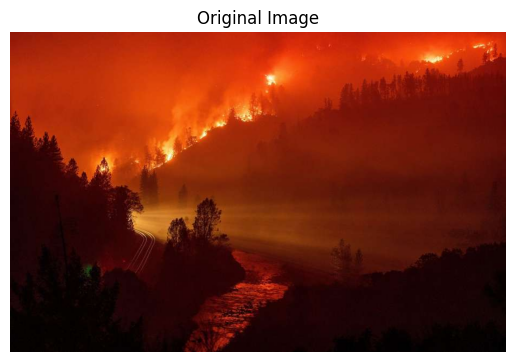

In [1]:

from train_cnn import TrainingModel, init_training_params, train_cnn, TRANSFORM, ModelWithTransform, get_image_data, visualize_loss_curve, visualize_first_layer_weights
import torch
import matplotlib.pyplot as plt
n_samples = 100
output_file_path = "test_model.pth"

print(f"Using {n_samples} images for training and testing.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {DEVICE}")
model = TrainingModel()

training_params = init_training_params(model, device = DEVICE)

# resize to 224x224 as preprocessing step
model_and_transform = ModelWithTransform(model, TRANSFORM)

train,val,test = get_image_data(n_samples)

print(len(train))

random_fire_img = None
for i in range(0, len(train)):
    if train[i][1]:
        random_fire_img = train[i][0]
        break

if random_fire_img is None:
    raise ValueError("No fire image found in the training set.")


# show original image
plt.imshow(random_fire_img.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Original Image")
plt.show()

random_fire_img = TRANSFORM(random_fire_img)




In [2]:


train_loss, val_loss ,fire_detector = train_cnn(model_and_transform,training_params,train, val)
# Save the trained model to a file
fire_detector.save_to_file(output_file_path)
print(f"Model saved to {output_file_path}")




Begin training...
Epoch 1 completed. Train loss: 3.7214, Validation loss: 1.8112
Epoch 2 completed. Train loss: 62.2619, Validation loss: 8.9303
Epoch 3 completed. Train loss: 11.9294, Validation loss: 4.3199
Epoch 4 completed. Train loss: 4.5979, Validation loss: 0.6795
Epoch 5 completed. Train loss: 0.8211, Validation loss: 0.7816
Epoch 6 completed. Train loss: 0.8170, Validation loss: 0.6702
Epoch 7 completed. Train loss: 0.6968, Validation loss: 0.6934
Epoch 8 completed. Train loss: 0.6939, Validation loss: 0.6941
Epoch 9 completed. Train loss: 0.6936, Validation loss: 0.6936
Epoch 10 completed. Train loss: 0.6933, Validation loss: 0.6932
Model saved to test_model.pth


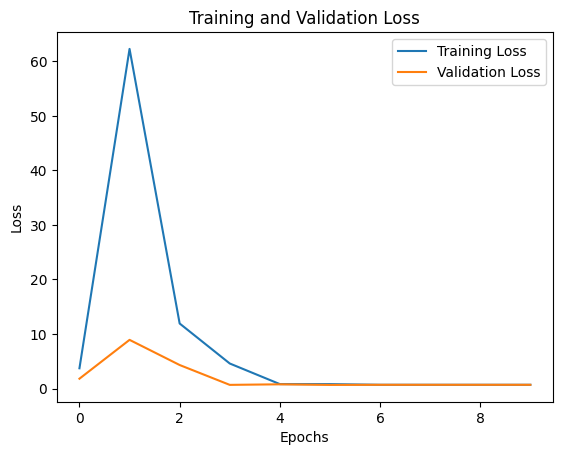

In [3]:
visualize_loss_curve(train_loss, val_loss)



Filters shape:  torch.Size([16, 3, 3, 3])
torch.Size([16, 3, 3, 3])


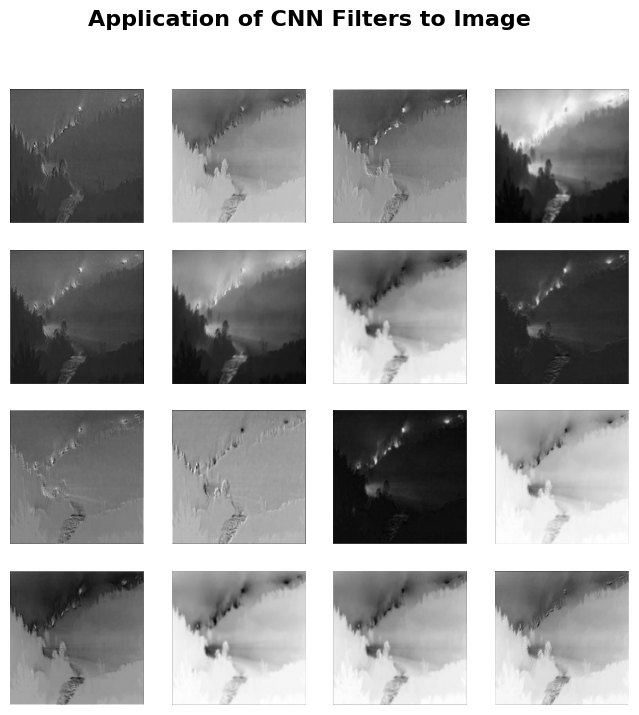

In [4]:
visualize_first_layer_weights(fire_detector.model.trained_model, random_fire_img)
